In [1]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
def getTrainingData(path, label, limit):
    trainImages = []
    
    c = 1
    for file in os.listdir(path):
        if file.endswith('.png') == False:
            continue
            
        filePath = os.path.join(path, file)
        img = cv.imread(filePath)
        img = cv.resize(img, (128, 128))
        trainImages.append([img, label])
    
        if c == limit:
            break

        c += 1
        
    return np.array(trainImages)

In [3]:
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import load_model
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *

Using TensorFlow backend.


In [4]:
k1 = getTrainingData('data/Dataset/v2/1', [1 ,0, 0, 0], 80)
k2 = getTrainingData('data/Dataset/v2/2', [0, 1, 0, 0], 80)
k3 = getTrainingData('data/Dataset/v2/3', [0, 0, 1, 0], 80)
k4 = getTrainingData('data/Dataset/v2/4', [0, 0, 0, 1], 80)
training_images = np.concatenate((k1, k2, k3, k4), axis = 0)
training_data = np.array([i[0] for i in training_images])
training_label = np.array([i[1] for i in training_images])

In [ ]:
training_data.shape

In [ ]:
class StopLearning(Callback):
    
    def __init__(self, X, Y):
        super(Callback, self).__init__()
        self.X = X
        self.Y = Y
    
    def on_epoch_end(self, epoch, logs = {}):
        loss, acc = self.model.evaluate(self.X, self.Y)
        print('Akurasi : ' + str(acc * 100))
        
        if acc > 0.99:
            self.model.stop_training = True
            
        if acc >= 0.9:
            self.model.save('hasil learning/Model CNN ' + str(acc * 100) + '.h5')
            print("Saved model to disk")
            

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu', input_shape = (128, 128, 3)))
model.add(MaxPool2D(pool_size = 3, padding = 'same'))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = 3, padding = 'same'))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = 3, padding = 'same'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(700, activation = 'sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(500, activation = 'sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(4, activation = 'softmax'))
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics=['accuracy'])

fit = model.fit(x = training_data, y = training_label, epochs = 1000, batch_size = 30, verbose = 2, callbacks = [StopLearning(training_data, training_label)])
        
model.summary()
loss, accuracy = model.evaluate(training_data, training_label)
print('Akurasi :' + str(accuracy * 100))

In [ ]:
loss, accuracy = model.evaluate(training_data, training_label)
model_json = model.to_json()
with open("hasil learning/v2/model CNN " + str(accuracy * 100) + ".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("hasil learning/v2/model CNN " + str(accuracy * 100) + ".h5")
print("Saved model to disk")

In [ ]:
loaded_model = load_model('hasil learning/Model CNN 99.0625.h5')
loaded_model.compile(loss = 'categorical_crossentropy', optimizer= 'sgd', metrics=['accuracy'])
fit = loaded_model.fit(x = training_data, y = training_label, epochs = 500, batch_size = 30, verbose = 2, callbacks = [StopLearning(training_data, training_label)])
        
loaded_model.summary()
loss, accuracy = loaded_model.evaluate(training_data, training_label)
print('Akurasi :' + str(accuracy * 100))

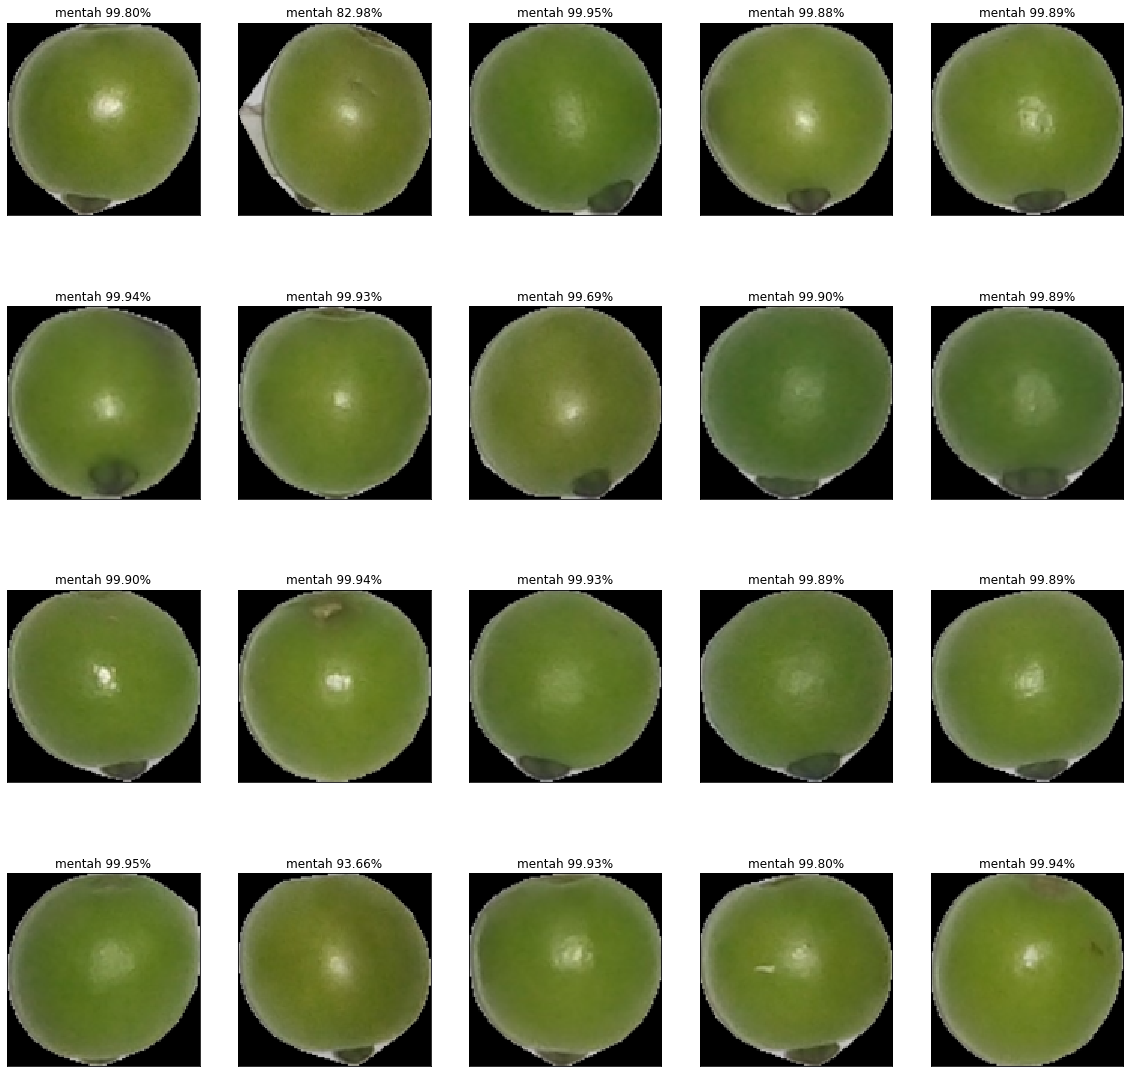

In [7]:
fig = plt.figure(figsize = (20, 20))
indeks = ['mentah', 'setah', 'setang', 'matang']

loaded_model = load_model('hasil learning/Model CNN 99.0625.h5')
for counter, data in enumerate(training_data[:20]):
    y = fig.add_subplot(4, 5, counter + 1)
    img = training_data[counter]
    output = loaded_model.predict([img.reshape(-1, 128, 128, 3)])
    
    y.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(indeks[np.argmax(output)] + ' {0:.2f}%'.format(np.max(output) * 100))
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)